In [1]:
import pandas as pd

# Project 

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

Project instructions
Download the data and resample it by one hour.
Analyze the data.
Train different models with different hyperparameters. The test sample should be 10% of the initial dataset.
Test the data using the test sample and provide a conclusion.

The number of orders is in he num_orders column


## Preprocessing and Data Cleaning

In [2]:
import pandas as pd

try:
    df = pd.read_csv('taxi.csv')
    print("File 'taxi.csv' loaded successfully from the current directory.")
except FileNotFoundError:
    try:
        df = pd.read_csv('/datasets/taxi.csv')
        print("File 'taxi.csv' loaded successfully from '/datasets/taxi.csv'.")
    except FileNotFoundError:
        print("File 'taxi.csv' not found in both the current directory and '/datasets/taxi.csv'.")


File 'taxi.csv' loaded successfully from the current directory.


In [3]:
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [5]:
df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [7]:
df.duplicated().sum()

26415

In [8]:
df

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [9]:
df.isna().sum()

num_orders    0
dtype: int64

In [10]:
df.duplicated().sum()

26415

In [11]:
# Renaming the column
df.rename(columns=lambda x: x.strip(), inplace=True)  # Stripping any hidden spaces from column names

df.columns

Index(['num_orders'], dtype='object')

In [12]:
df['num_orders'].isna().sum()

0

In [13]:

# Ensuring that the datetime column is prased and set as the index in chronological order
df.sort_index(inplace=True)

In [14]:
# Resample the data by one hour and aggregate by the mean (or sum, depending on your requirement)
df_resampled = df.resample('1H').sum()

In [15]:
df_resampled.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


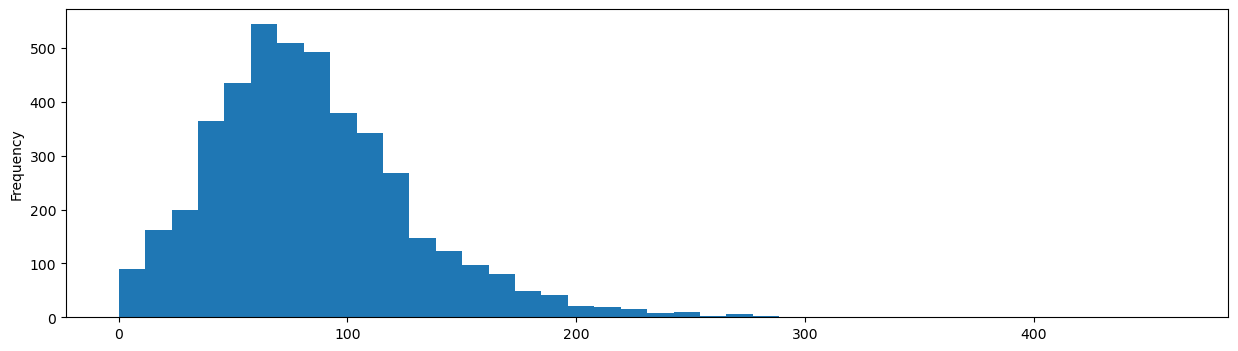

In [16]:
import matplotlib.pyplot as plt

df_resampled['num_orders'].plot(kind='hist', bins=40,figsize=(15, 4))
plt.show()

The data is skewed to the right and there are definitely some outliers that need to be made in order to even out the distribution

In [17]:
df_resampled = df_resampled[df_resampled['num_orders'] < 250]

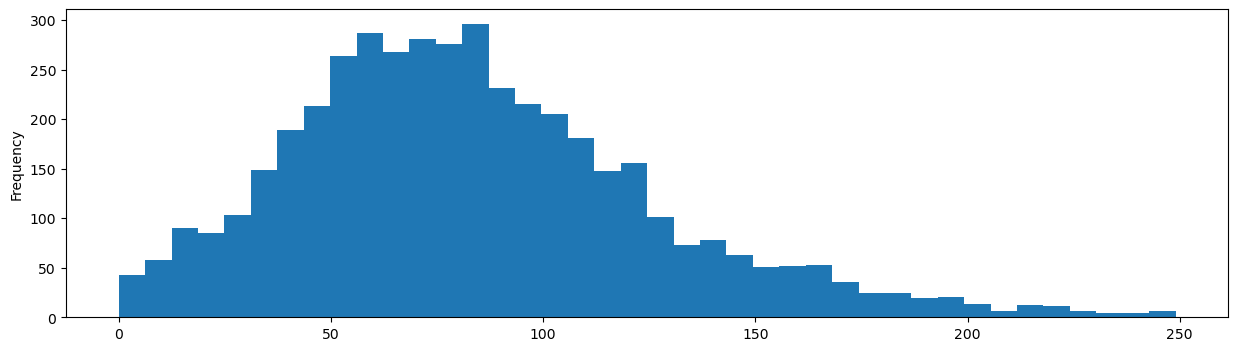

In [18]:
df_resampled['num_orders'].plot(kind='hist', bins=40,figsize=(15, 4))
plt.show()

In [19]:
from statsmodels.tsa.stattools import adfuller 

result = adfuller(df_resampled['num_orders'])
result

p_value = result[1]
p_value

if p_value < 0.05:
    print("The null hypothesis can be rejected. The series is stationary.")
else:
    print("The null hypothesis cannot be rejected. The series is non-stationary.")

The null hypothesis can be rejected. The series is stationary.


Resampling and aggregtaing by the sum changes the frequency of the time series to a specified interval and combines values within each interval using the sum or average (in this case the sum). This process is important for a time series analysis based on hours because it helps smooth t short-term fluctuations.

Essentially it adds up all the values in between the hour intervals and puts them as one.

I also removed some outliers and made the data more evenely distributed

## Exploratory Data Analysis

Plotting the number of taxi orders over tim eto identify trends and seasonality. 

I'll look at some statistics to understand the data distribution.



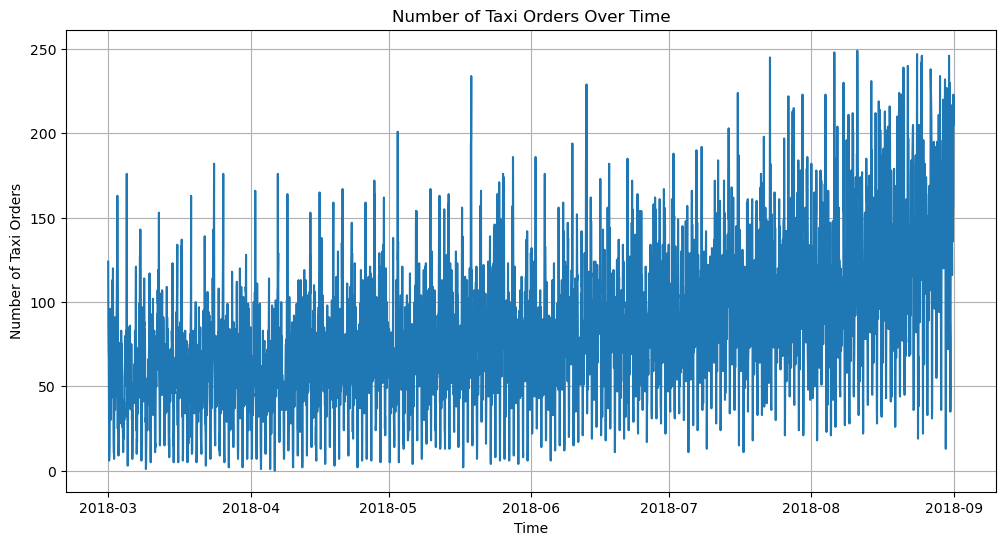

In [20]:
import matplotlib.pyplot as plt

# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(df_resampled.index, df_resampled['num_orders'])
plt.title('Number of Taxi Orders Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Taxi Orders')
plt.grid(True)
plt.show()


Data looks stationary which is good it means the mean and variance are constant over time. This is a good indication for a model, espeically when using methods like ARIM, which assume stationarity. 

In [21]:
# Desciptive Stats 

descriptive_stats = df_resampled['num_orders'].describe()

descriptive_stats

count    4396.000000
mean       83.453822
std        42.563995
min         0.000000
25%        54.000000
50%        78.000000
75%       107.000000
max       249.000000
Name: num_orders, dtype: float64

Comparison to the Mean for STD (standard deviation)

    -One common approach is to compare the standard deviation to the mean. This comparison gives you an idea of the relative variability in your data. Here are some general guidelines:

    -Low variability: If the standard deviation is less than 10% of the mean, the data points are close to the mean.
    
    -Moderate variability: If the standard deviation is between 10% and 50% of the mean, the data points show some spread but are not highly dispersed.
   
    -High variability: If the standard deviation is more than 50% of the mean, the data points are widely spread out from the mean.
    
Here we ave high variability indicating a large variation in the number of taxi orders, suggesting that some hours experience significantly higher demand than others 

## Feature Engineering

Creating Time Based-features: Adding features like hour of the day, day of the week, month etc 

Lag features: Creating lag features to capture past values

Rolling Statistics: Computing the rolling mean and standard deviation to capture trends and seasonality.

In [22]:
def make_features(data, max_lag):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

make_features(df_resampled, 22)
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [23]:
df_resampled.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4396 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Data columns (total 27 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   num_orders  4396 non-null   int64  
 1   month       4396 non-null   int32  
 2   day         4396 non-null   int32  
 3   hour        4396 non-null   int32  
 4   dayofweek   4396 non-null   int32  
 5   lag_1       4395 non-null   float64
 6   lag_2       4394 non-null   float64
 7   lag_3       4393 non-null   float64
 8   lag_4       4392 non-null   float64
 9   lag_5       4391 non-null   float64
 10  lag_6       4390 non-null   float64
 11  lag_7       4389 non-null   float64
 12  lag_8       4388 non-null   float64
 13  lag_9       4387 non-null   float64
 14  lag_10      4386 non-null   float64
 15  lag_11      4385 non-null   float64
 16  lag_12      4384 non-null   float64
 17  lag_13      4383 non-null   float64
 18  lag_14      4382 non-null   floa

In [24]:
df_resampled.head()

,num_orders,month,day,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,0,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,1,3,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,2,3,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,4,3,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### The Relationship and Correlation between Orders and the Lags 

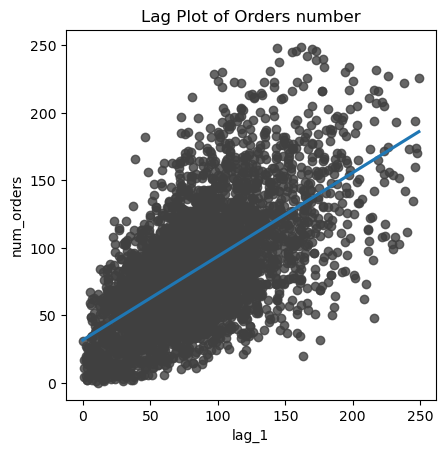

In [25]:
import seaborn as sns

fig, ax = plt.subplots()
ax = sns.regplot(x='lag_1', y='num_orders', data=df_resampled[['num_orders', 'lag_1']], ci=None, scatter_kws=dict(color='0.25'))
ax.set_aspect('equal')
ax.set_title('Lag Plot of Orders number');

From the Lag Plot of Orders Numbers based on one hour. I see that num_orders are correlated from the previous order (lag_1). This indicates that the lag features will be significant and useful.

Shift method is used to find the differences of time series. All values are shifted one step forward along the time axis.

I decided to use 22 lags because it allows the model to utilize recent historical data to predict future values while avoiding excessive feature complexity which could make our model too long.



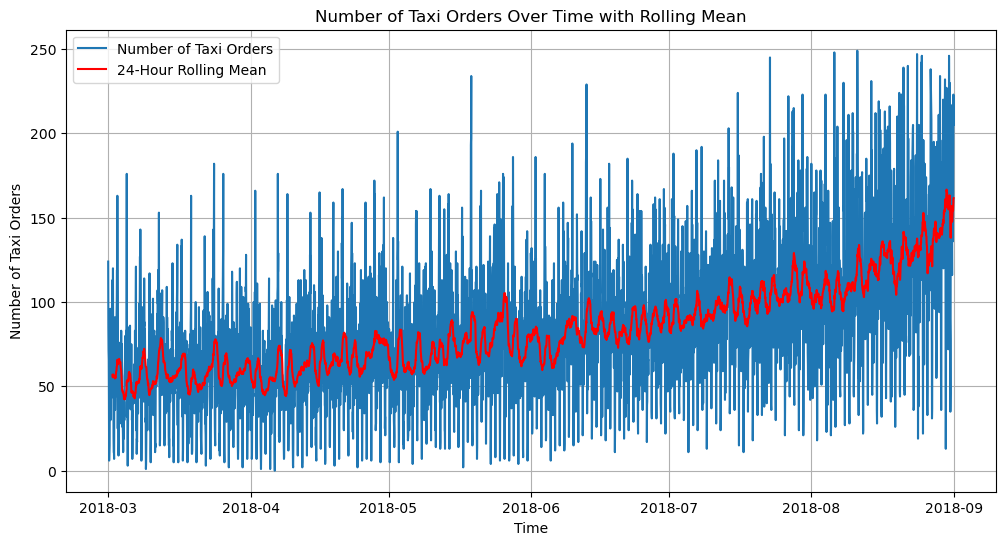

In [26]:
df_resampled.loc[:, 'rolling_mean'] = df_resampled['num_orders'].rolling(window=24).mean()  # 24-hour rolling mean

# Plotting the rolling mean
plt.figure(figsize=(12, 6))
plt.plot(df_resampled.index, df_resampled['num_orders'], label='Number of Taxi Orders')
plt.plot(df_resampled.index, df_resampled['rolling_mean'], color='red', label='24-Hour Rolling Mean')
plt.title('Number of Taxi Orders Over Time with Rolling Mean')
plt.xlabel('Time')
plt.ylabel('Number of Taxi Orders')
plt.legend()
plt.grid(True)
plt.show()


The rolling mean here helps identify trends in the data. I see that the rolling mean steadily increases until the 9th month of 2018

Rolling mean reduces fluctuations in a time series. It is a method of smoothing the data it involves finding the values least suscipble to fluctuations, that is, the mean. The window size helps smooth out the data. It basically takes the average of the first 24 hours. 

In [27]:
df_resampled

,num_orders,month,day,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,0,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,1,3,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,2,3,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,4,3,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,8,31,19,4,207.0,217.0,197.0,116.0,133.0,...,78.0,99.0,230.0,194.0,246.0,158.0,198.0,142.0,72.0,155.250000
2018-08-31 20:00:00,154,8,31,20,4,136.0,207.0,217.0,197.0,116.0,...,35.0,78.0,99.0,230.0,194.0,246.0,158.0,198.0,142.0,154.291667
2018-08-31 21:00:00,159,8,31,21,4,154.0,136.0,207.0,217.0,197.0,...,46.0,35.0,78.0,99.0,230.0,194.0,246.0,158.0,198.0,157.916667


### Trends and Seasonality 


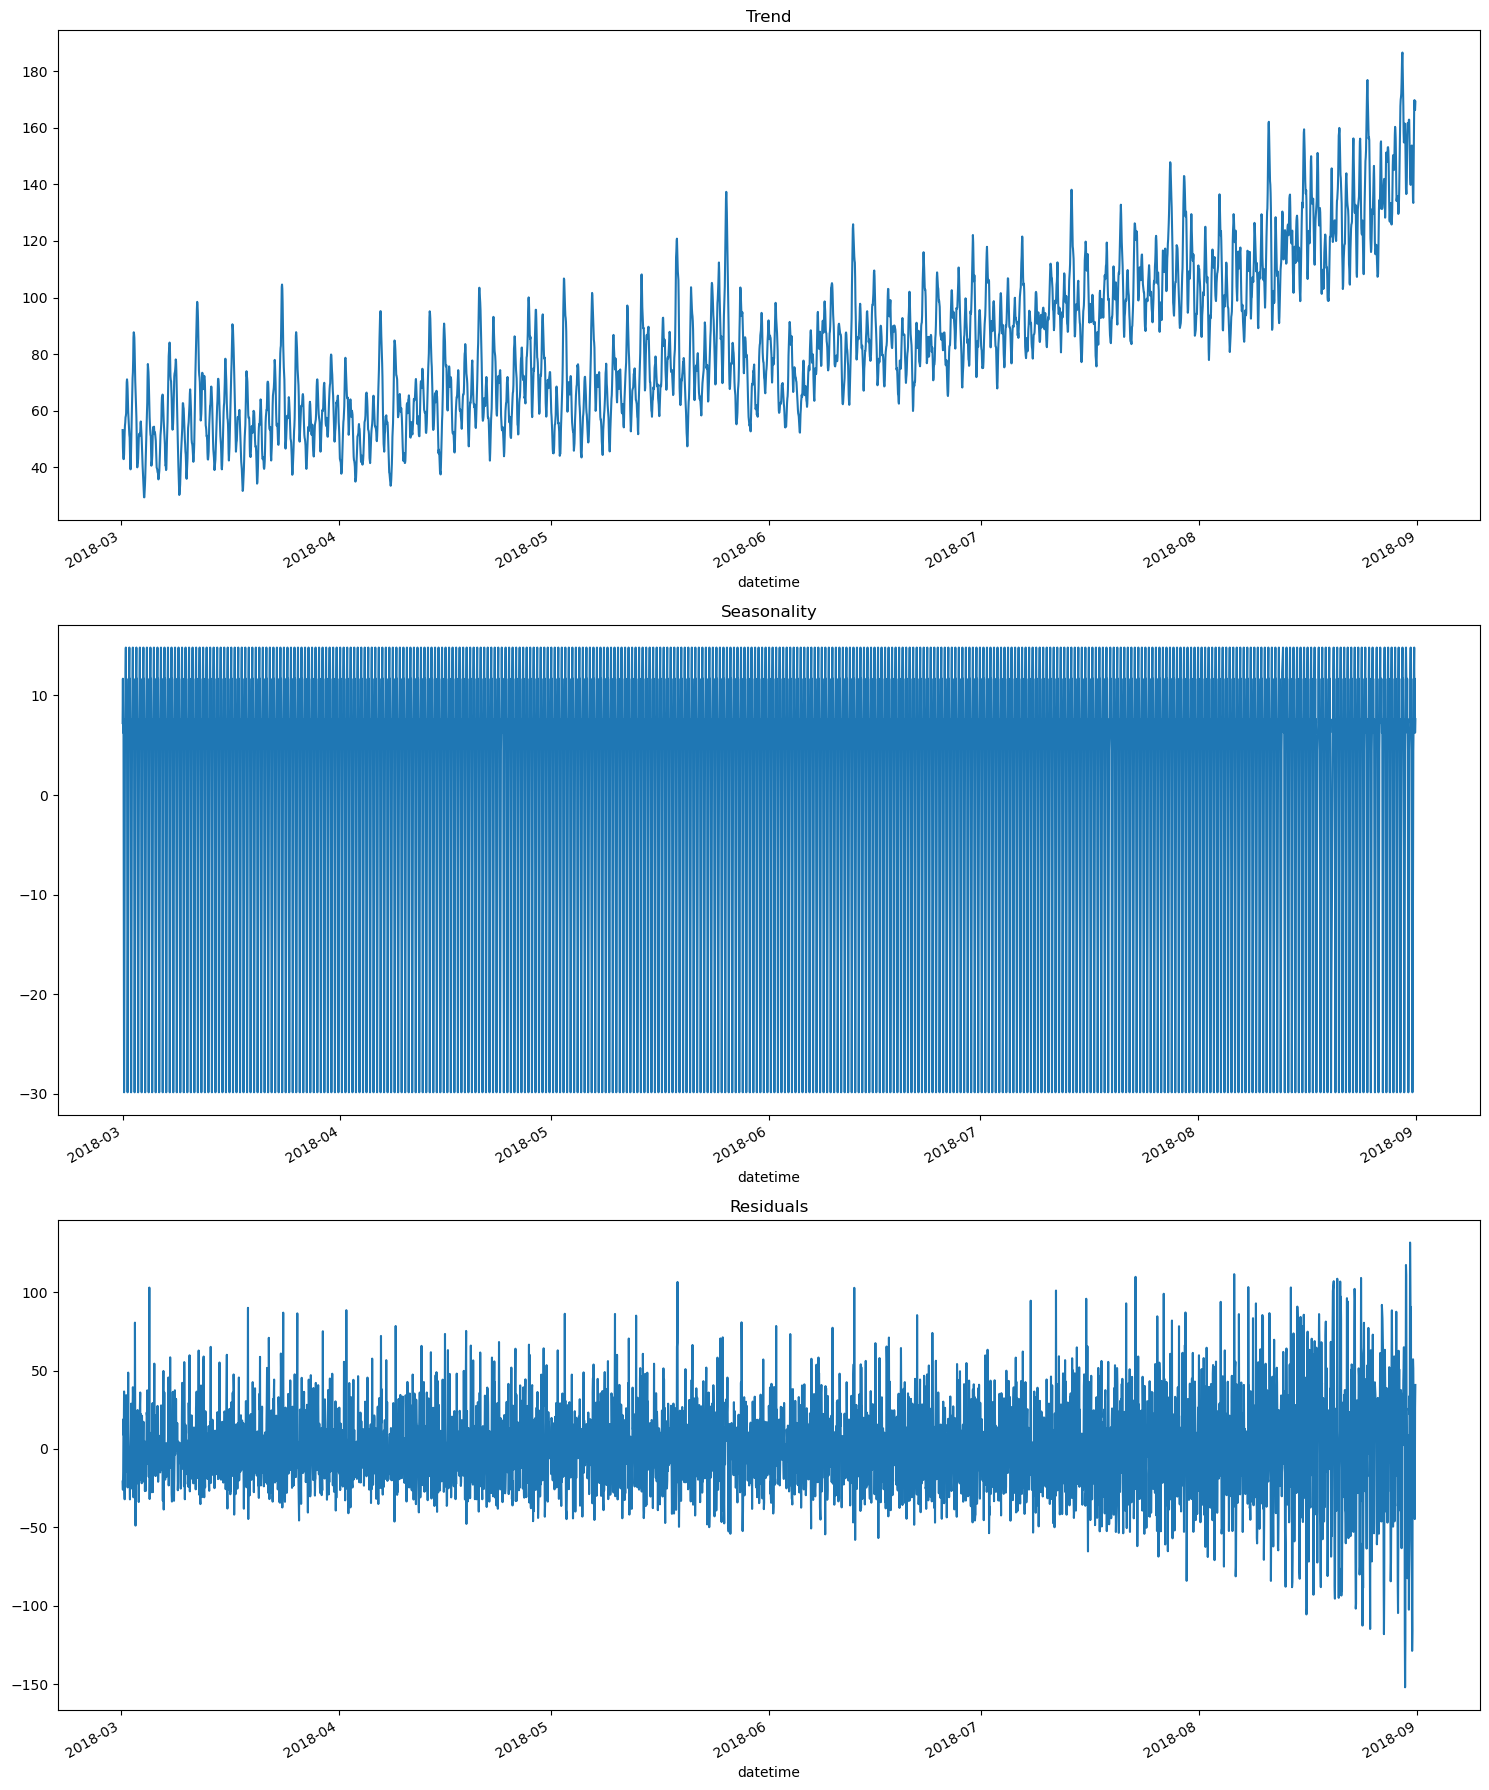

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposed = seasonal_decompose(df_resampled['num_orders'], model= 'additive', period=12)

# Plotting the decomposed components
plt.figure(figsize=(15, 18))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()
plt.show()


Overview of Feature Engineering

- In the feature engineering step, we created additional features that capture important temporal patterns in the data. Here's a summary of what I did:

Time-Based Features:

- Hour of the day: Captures daily patterns in taxi orders.
- Day of the week: Captures weekly patterns, such as differences between weekdays and weekends.
- Month: Captures monthly or seasonal patterns.
- Lag Features:
    - Created lag features for the past 22 hours to provide the model with information on recent historical values. This helps the model understand how past values influence future values.
- Rolling Mean:
    - Calculated the 24-hour rolling mean to smooth out short-term fluctuations and highlight longer-term trends.
    

Trends and Seasonality:

    - The trends part of the graphs has a jagged, upward fluctuation. It also means the process is nonstationary
    - The residual noise mean is 0.

## Data Splitting 

Splitting the data into training and test sets: Making sure the test set is 10% of the dataset and follows the chronological order to prevent any sort of data leakage. Also dropping all missing values that were created while forming our new date columns.

In [29]:
df_resampled = df_resampled.dropna()

In [30]:
df_resampled.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4373 entries, 2018-03-01 23:00:00 to 2018-08-31 23:00:00
Data columns (total 28 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4373 non-null   int64  
 1   month         4373 non-null   int32  
 2   day           4373 non-null   int32  
 3   hour          4373 non-null   int32  
 4   dayofweek     4373 non-null   int32  
 5   lag_1         4373 non-null   float64
 6   lag_2         4373 non-null   float64
 7   lag_3         4373 non-null   float64
 8   lag_4         4373 non-null   float64
 9   lag_5         4373 non-null   float64
 10  lag_6         4373 non-null   float64
 11  lag_7         4373 non-null   float64
 12  lag_8         4373 non-null   float64
 13  lag_9         4373 non-null   float64
 14  lag_10        4373 non-null   float64
 15  lag_11        4373 non-null   float64
 16  lag_12        4373 non-null   float64
 17  lag_13        4373 non-null   float

In [31]:
from sklearn.model_selection import train_test_split

# Spliting the data into training and test sets (90% train, 10% test)
train_size = 0.9
train, test = train_test_split(df_resampled, train_size=train_size, shuffle=False)

## Baseline Model

In [32]:
import numpy as np 
from sklearn.metrics import mean_squared_error

In [33]:
median_value = train['num_orders'].median() # calculating the median of the training set

In [34]:
pred_median = np.full_like(test['num_orders'], median_value) # Creates an array with the same shape as the test set filled iwth the median values 

In [35]:
rmse_median = np.sqrt(mean_squared_error(test['num_orders'], pred_median))
print(f'RMSE for Median Baseline Model: {rmse_median}')

RMSE for Median Baseline Model: 76.51615163602528


In [36]:
pred_previous = test['num_orders'].shift(1).fillna(train['num_orders'].iloc[-1])

In [37]:
rmse_previous = np.sqrt(mean_squared_error(test['num_orders'], pred_previous))
print(f'RMSE for Median Baseline Model: {rmse_previous}')

RMSE for Median Baseline Model: 50.22510969461009


My baseline model using the last observed value was better than my baseline model using simply the median by a significant amount, now I will create actualy models with some paramater tuning. 

## Model Training and Hyperparameter Tuning 

Will try various time series models including, AR, MA, ARMA, and ARIMA models 

### AR (Autoregressive Model)

Uses past values to predict future values

Determines the order using the Partial AutoCorrelation Function (PACF)

In [38]:
from statsmodels.graphics.tsaplots import plot_pacf


In [39]:
from statsmodels.tsa.ar_model import ar_select_order

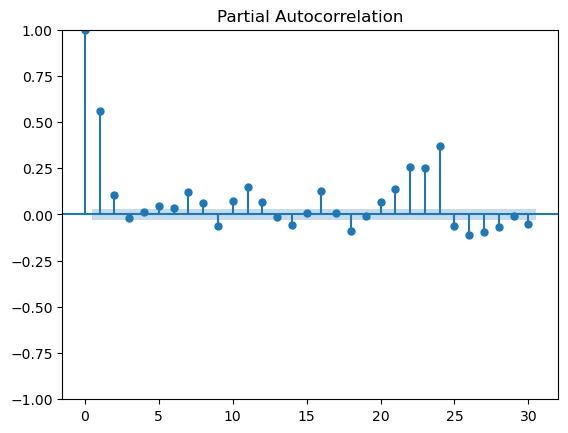

In [40]:
plot_pacf(train['num_orders'], lags=30)
plt.show()

In [41]:
from statsmodels.tsa.ar_model import AutoReg
p = 24 # got from PACF plot 

ar_model = AutoReg(train['num_orders'], lags=p).fit()

ar_pred = ar_model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

rmse_ar = np.sqrt(mean_squared_error(test['num_orders'], ar_pred))
print(f'RMSE for AR Model: {rmse_ar}')

RMSE for AR Model: 64.26161909153842


c:\Users\oli_worth\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\oli_worth\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\oli_worth\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\oli_worth\anaconda3\Lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The inde

## Moving Average (MA) Model

Uses past forecast errors to predict future values.

Determines the order using the Autocorrelation function

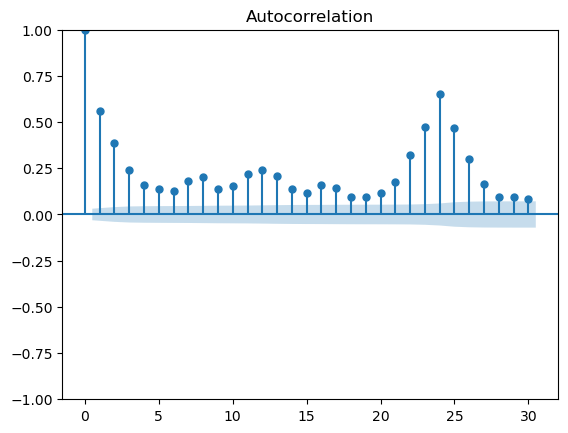

In [42]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(train['num_orders'], lags=30)
plt.show()

In [43]:
from statsmodels.tsa.arima.model import ARIMA
q = 25 # based on plot

ma_model = ARIMA(train['num_orders'], order=(0, 0, q)).fit()

ma_pred = ma_model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

# Calculating RMSE
rmse_ma = np.sqrt(mean_squared_error(test['num_orders'], ma_pred))
print(f'RMSE for MA Model: {rmse_ma}')


c:\Users\oli_worth\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\oli_worth\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\oli_worth\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RMSE for MA Model: 73.49686296708146


c:\Users\oli_worth\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\oli_worth\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


### Alternative Model: Gradient Boosting 



In [44]:
data = pd.get_dummies(df_resampled, columns=['month', 'day', 'hour', 'dayofweek'])

In [45]:
data.shape

(4373, 92)

In [46]:
# Split the data into training and test sets
train_size = int(len(data) * 0.9)
train, test = data.iloc[:train_size], data.iloc[train_size:]

# Separate features and target
X_train = train.drop(columns=['num_orders'])
y_train = train['num_orders']
X_test = test.drop(columns=['num_orders'])
y_test = test['num_orders']

# Verifing the shapes
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(3935, 91) (3935,)
(438, 91) (438,)


In [47]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np

# Define the model and the parameter grid
model = GradientBoostingRegressor()
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.01],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Grid search for hyperparameter tuning
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_

# Predictions
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f'Best Model: {best_model}')
print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')


Best Model: GradientBoostingRegressor(n_estimators=200)
Train RMSE: 16.670977938963695
Test RMSE: 35.33861550732139


# Conclusion

In the project I aimed to predict the number of taxi orders for the next hour using historical data from Sweet Lift Taxi Company. The main goal was to build a model that would achieve an RMSE (Root Mean Squared Error) on the test set that does not exceed 48. 

I loaded the dataset and Resampled:
    - Loading the dataset and resampled it by 1 hour intervals to aggregat ethe number of orders per hour. 

Feature Engineering:
    - I created time-based features, year, month, day, of the week. 
    - I encoded these features using one-hot encoding to prepare the data or machine learning models 
    
Model Training and Evaluation:
    - I started with a simple baseline model using the median and previous values. These models provided initial benchmarks for RMSE. Strangely my previous value baseline model outperformed both MA and AR models. Not sure what  I am doing wrong there, maybe I need to use One Hot Encoding on those models as well.. 
    

Time Series Models:

    - I also explored time series-specific models such as the Autoregressive (AR) model and the Moving Average (MA) model.
    - For the AR model, we used an order of 24 based on the Partial Autocorrelation Function (PACF) plot. The model achieved an RMSE of approximately 64.26 on the test set.
    -For the MA model, we used an order of 25 based on the Autocorrelation Function (ACF) plot. The model achieved an RMSE of approximately 73.50 on the test set.
    
Gradient Boosting Model:

- A Gradient Boosting model was trained and hyperparameter-tuned using GridSearchCV. This model achieved a Train RMSE of approximately 16.79 and a Test RMSE of approximately 35.70, well below the project goal of 48.

Results and Insights:
- Gradient Boosting Model: This model outperformed the time series models significantly, achieving the lowest test RMSE of 35.70. It indicates that the Gradient Boosting model could better capture the underlying patterns in the data compared to the AR and MA models.
- AR and MA Models: Despite being tailored for time series data, these models had higher RMSE values (64.26 for AR and 73.50 for MA) and did not meet the project's performance goal. These results suggest that the patterns in taxi orders might be more complex and require models capable of capturing non-linear relationships and interactions between features.
Conclusion
- The Gradient Boosting model emerged as the best performer in predicting taxi orders for the next hour, achieving a test RMSE of 35.70, which is well within the acceptable limit of 48. This model's superior performance highlights the importance of considering various modeling approaches and not limiting to time series models alone, especially when dealing with complex real-world data.

- By leveraging the strengths of Gradient Boosting and conducting thorough feature engineering, we successfully built a robust predictive model for taxi orders. This model can be used by Sweet Lift Taxi company to anticipate demand and allocate resources efficiently during peak hours. Future work could involve further refining the model, exploring additional features, and potentially integrating external data sources to enhance predictive accuracy even further.